In [1]:
import pandas as pd
import numpy as np


seed = 44
np.random.seed(seed)

print("Reading file...")
all_df = pd.read_csv('./data.csv', low_memory=False)
print("Done reading!")

Reading file...
Done reading!


In [2]:
# Sanity Check
print(all_df.keys())

Index(['steamId', 'itadPlain', 'itad.position', 'itad.rank', 'steam.name',
       'steam.steam_appid', 'steam.required_age', 'steam.is_free', 'steam.dlc',
       'steam.reviews',
       ...
       'steam.short_description.compound', 'steam.ext_user_account_notice',
       'timestamp', 'year', 'month', 'day', 'daysSinceLaunch', 'price',
       'percentOfReleasePrice', 'isSteamSale'],
      dtype='object', length=131)


In [3]:
pd.to_datetime(all_df['timestamp'] * 1000000000)

0         2017-03-03 00:30:00
1         2017-03-04 00:30:00
2         2017-03-05 00:30:00
3         2017-03-06 00:30:00
4         2017-03-07 00:30:00
                  ...        
4407820   2022-03-03 00:30:00
4407821   2022-03-04 00:30:00
4407822   2022-03-05 00:30:00
4407823   2022-03-06 00:30:00
4407824   2022-03-07 00:30:00
Name: timestamp, Length: 4407825, dtype: datetime64[ns]

In [4]:
all_df.dtypes

steamId                    int64
itadPlain                 object
itad.position              int64
itad.rank                  int64
steam.name                object
                          ...   
day                        int64
daysSinceLaunch            int64
price                    float64
percentOfReleasePrice    float64
isSteamSale                 bool
Length: 131, dtype: object

In [5]:
all_df['time'] = pd.to_datetime(all_df['timestamp'] * 1000000000)

In [6]:
all_df['time']

0         2017-03-03 00:30:00
1         2017-03-04 00:30:00
2         2017-03-05 00:30:00
3         2017-03-06 00:30:00
4         2017-03-07 00:30:00
                  ...        
4407820   2022-03-03 00:30:00
4407821   2022-03-04 00:30:00
4407822   2022-03-05 00:30:00
4407823   2022-03-06 00:30:00
4407824   2022-03-07 00:30:00
Name: time, Length: 4407825, dtype: datetime64[ns]

In [7]:
all_df = all_df.rename({'time': 'ds', 'price': 'y'}, axis='columns')

We want to predict `percentOfReleasePrice` instead of just `price` because of the following:
  - games can start at many prices
  - the starting price of a game is variable (changes over time)
    - e.g. a AAA game in 2015 released at $60, now the base release price is $80
    - It usually jumps in 5-10 dollar increments to keep the consumer happy.
    - @christian can you please find a citation for this or similar metric? Basically want to say that there is a trend in price (but trend is discrete as well)
  - Game launch price is immediately available, if the game is available
    - It's also very easy to translate an absolute price (e.g. $20) into a % of the release price, so it stays user-friendly as well.
  - If we normalize, we'll be able to generalize more (it's more effective when predicting between 0 and 1, rather than having a varying range)
    - We should be normalizing data anyway for ML lol

In [8]:
all_df['y']

0          80.4826
1          70.8900
2          70.8900
3          70.8900
4          70.8900
            ...   
4407820    11.2900
4407821    11.2900
4407822    11.2900
4407823    11.2900
4407824    10.1900
Name: y, Length: 4407825, dtype: float64

<AxesSubplot:ylabel='Frequency'>

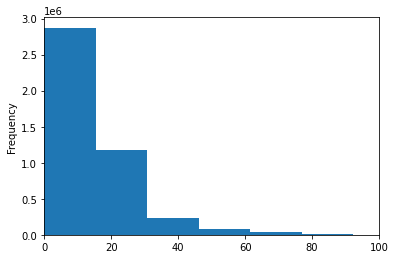

In [9]:
# Look at the average proportions of how the prices are distributed
all_df['y'].sort_index().plot.hist(bins=20, xlim=(0, 100), x="Cost ($)", y="Frequency (Days)")

We can see that most games for most of the time like to stay at their original release price.
There are no games that have increased in price.
Games do not like 20%, 30% discounts, but rather like having stuff at 20-50% of its original price.
Discount percentage prefers to be in a nice, human-readable number (0.25, 0.4, 0.5)
  - 0.53, 0.54 disprove this rule

In [10]:
# Split each game into its own dataframe for easier forecasting
dfs = [v for k, v in all_df.groupby('itadPlain')]
len(dfs)

2227

In [11]:
# One dataframe per game, in a list.
dfs[0].head()

,steamId,itadPlain,itad.position,itad.rank,steam.name,steam.steam_appid,steam.required_age,steam.is_free,steam.dlc,steam.reviews,...,steam.ext_user_account_notice,timestamp,year,month,day,daysSinceLaunch,y,percentOfReleasePrice,isSteamSale,ds
2749246,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.455928e+09,2016,2,20,0,13.7522,NaN,False,2016-02-20 00:30:00
2749247,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456015e+09,2016,2,21,1,10.9900,NaN,False,2016-02-21 00:30:00
2749248,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456101e+09,2016,2,22,2,10.9900,NaN,False,2016-02-22 00:30:00
2749249,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456187e+09,2016,2,23,3,10.9900,NaN,False,2016-02-23 00:30:00
2749250,15560,aaaaaaaaaaaaaaaaaaaaaaaaaforawesome,1518,1227,AaaaaAAaaaAAAaaAAAAaAAAAA!!! for the Awesome,15560,0,False,0,False,...,False,1.456274e+09,2016,2,24,4,10.9900,NaN,False,2016-02-24 00:30:00


In [12]:
dfs[1].head()

,steamId,itadPlain,itad.position,itad.rank,steam.name,steam.steam_appid,steam.required_age,steam.is_free,steam.dlc,steam.reviews,...,steam.ext_user_account_notice,timestamp,year,month,day,daysSinceLaunch,y,percentOfReleasePrice,isSteamSale,ds
4262827,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.491957e+09,2017,4,12,0,13.59,NaN,False,2017-04-12 00:30:00
4262828,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.492043e+09,2017,4,13,1,13.59,NaN,False,2017-04-13 00:30:00
4262829,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.492130e+09,2017,4,14,2,13.59,NaN,False,2017-04-14 00:30:00
4262830,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.492216e+09,2017,4,15,3,13.59,NaN,False,2017-04-15 00:30:00
4262831,499890,aaero,2415,1733,Aaero,499890,0,False,5,True,...,False,1.492303e+09,2017,4,16,4,13.59,NaN,False,2017-04-16 00:30:00


In [13]:
# Let's try to naively throw our data into FB Prophet, and see what it spits out.
from prophet import Prophet

m = Prophet()
m.fit(dfs[0])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -68.445
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3021.48   9.87309e-06       70.4923      0.4714      0.4714      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       3021.61    0.00089931       136.248    7.26e-06       0.001      237  LS failed, Hessian reset 
     199       3021.68   9.99551e-08       77.5489      0.5307      0.5307      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       3021.68   1.79205e-07       71.7232      0.2481           1      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [14]:
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2568,2023-03-03 00:30:00,10.981083,8.125035,13.722053
2569,2023-03-04 00:30:00,10.969886,8.193739,13.967082
2570,2023-03-05 00:30:00,10.929387,8.084891,13.597505
2571,2023-03-06 00:30:00,10.879062,8.206759,13.460469
2572,2023-03-07 00:30:00,10.827996,8.114611,13.525102


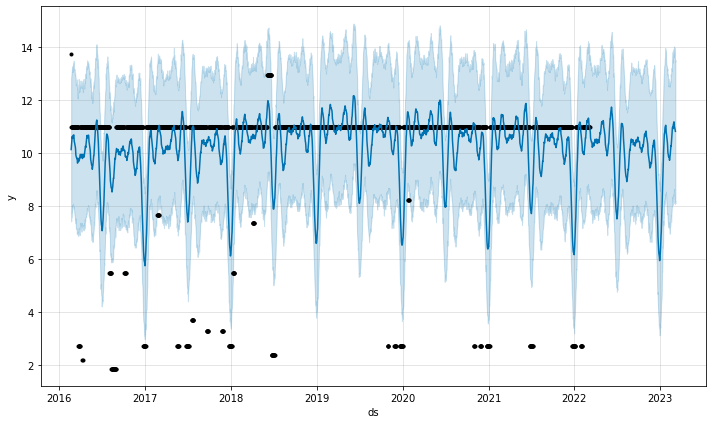

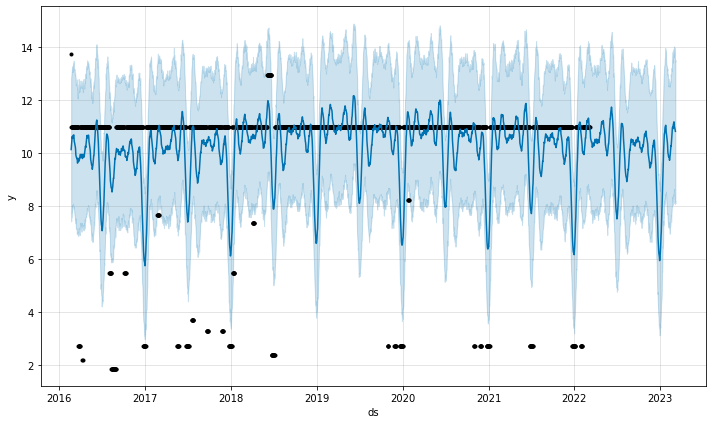

In [15]:
m.plot(forecast)

Hmm uhh..... This doesn't look good. Let's just look at the seasonal components for good measure.

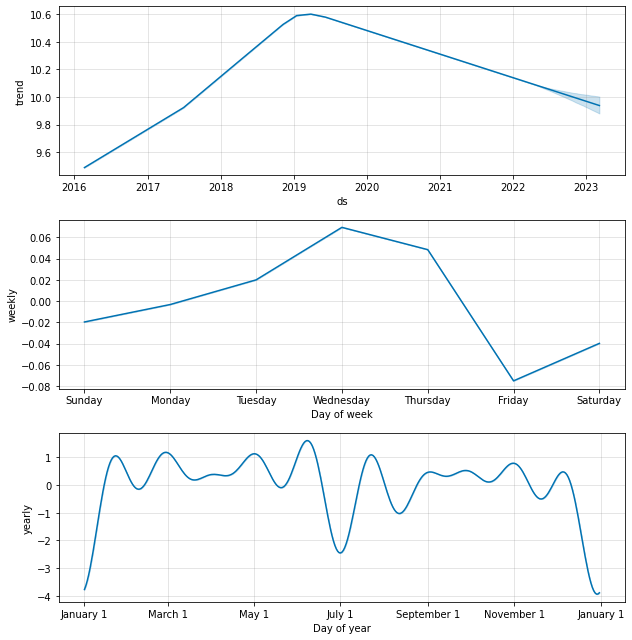

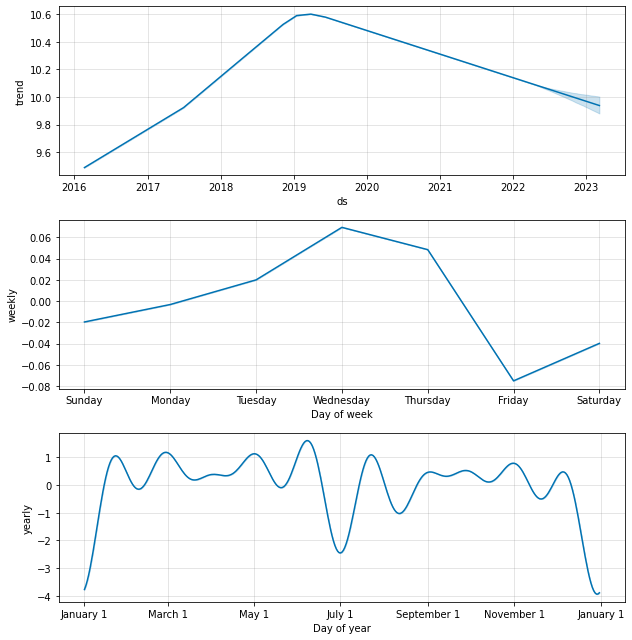

In [16]:
m.plot_components(forecast)

Looks kinda suspicious, and the values don't actually converge to where it's at, but this really does end up predicting the main sale points using yearly seasonality.
It also predicts how there's frequent weekend sales (Fri, Sat, Sun games cheaper than midweek).



In [17]:
# Let's just try it again with another game to make sure.
m = Prophet()
m.fit(dfs[1732])
future = m.make_future_dataframe(periods=365)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -153.267
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3371.46    0.00298136       98.6164           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       3373.11   0.000653098       81.5042   9.795e-06       0.001      229  LS failed, Hessian reset 
     177       3373.14   2.25213e-05       75.5177   3.208e-07       0.001      308  LS failed, Hessian reset 
     199       3373.14   1.29365e-06       66.7708       5.631      0.5631      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       3373.14    2.4404e-07        64.236           1           1      349   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,yhat,yhat_lower,yhat_upper
2568,2023-03-03 00:30:00,24.826616,17.180965,32.400143
2569,2023-03-04 00:30:00,24.935599,17.425824,32.441331
2570,2023-03-05 00:30:00,24.857501,17.119641,32.061961
2571,2023-03-06 00:30:00,24.734643,16.994608,32.186804
2572,2023-03-07 00:30:00,24.713734,17.071753,32.726470


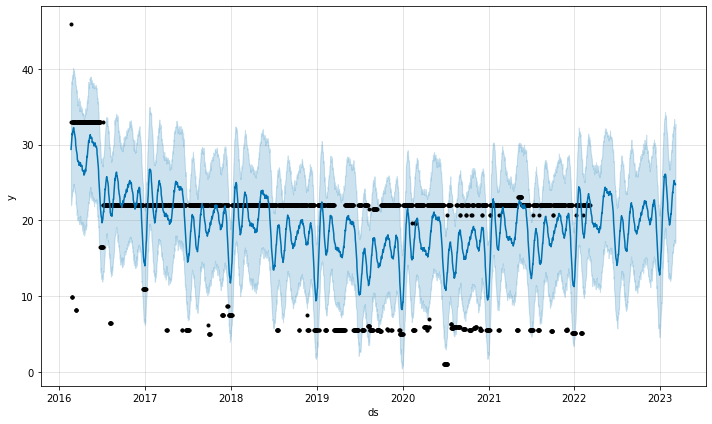

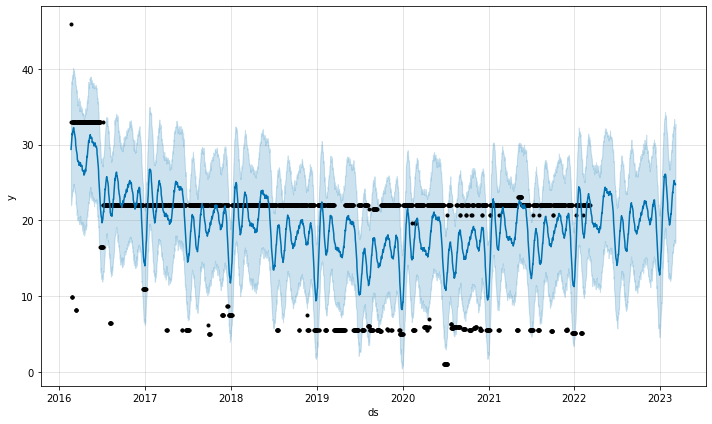

In [18]:
m.plot(forecast)

As we can see, this wasn't very good either. This is probably because sales are always discrete (jump from 100% to 40% price in a day, then jumping back up immediately.) For Prophet, as well as other ML models and the traditional methods (ARIMA, SARIMA, Holt-Winter) both expect a rather continuous distribution.

Let's take another look at our problem again.

We want to be able to predict the prices of games, yes, but why do we want that? We want to predict the prices so that users can decide whether they want to wait or not in order to get a game at a certain price.

That means that the actual proportion of time in a given sliding window (or a given time period) does not matter. Only if it reached it.

This reasoning gives us 3 options (all done using sliding windows of 7, 30, 90, 180 days):
 - Bucket the `percentOfOriginalPrice` into intervals of 0.8 or 0.1, and predict whether a given interval will show up
    - This is just logistic regression a bunch of times isn't it.
    - I predict that this one will work the best, and will be the most usable.
 - If we actually care about proportion of time it will show up, we can make it show the % of the sliding window being in a given bucket.
    - This will make the data more continuous (as data enters the sliding window it will slowly change the % values), but at the same time, we don't really care about the % of time that a game is a given price. Just that it reaches a cheap enough price.
    - If we make it continuous, we should be able to use the original models we wanted to use (Prophet, SARIMA, etc)
 - Our "original" idea, which is to:
   - cluster games by trends (k-mean or som)
     - SOM = self-organizing map
        - https://github.com/JustGlowing/minisom
        - https://www.kaggle.com/code/izzettunc?scriptVersionId=56314361&cellId=37
     - Dynamic time barycenter averaging
       - https://www.kaggle.com/code/izzettunc?scriptVersionId=56314361&cellId=44
       - ts-learn
       - Extra important because new games will be coming in at different times, however will still most likely follow the same trends (e.g. get to half price by the end of 3 years)
         - alternatively, we could use "Days since launch" column instead of timestamp as a way to phase time since launch date.
     - k-means
       - use DTW (dynamic time warping)
       - Either way, we try to follow the clustering ideas presented in the Kaggle notebook.
   - from those group results, run a rule-finder or make a classifier so that we can find a trend, given a game's attributes (e.g. multiplayer, supports linux, has 2 developers)
   - Run the classifier, then use that trend model to predict.

In [19]:

def nparray_tail(x: np.array, n:int):
    """
    Returns tail N elements of array.
    :param x: Numpy array.
    :param n: N elements to return on end.
    :return: Last N elements of array.
    """
    if n == 0:
        return x[0:0]  # Corner case: x[-0:] will return the entire array but tail(0) should return an empty array.
    else:
        return x[-n:]  # Normal case: last N elements of array.

Now, let's try to establish our train/test split.

We'll do

In [20]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler



onlyTrend = []


for df in dfs:
    onlyTrend.append(df['y'])

trends = np.array(onlyTrend)
nparray_tail(trends, 2)


/usr/local/lib/python3.8/dist-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/tmp/ipykernel_19839/3701976427.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  trends = np.array(onlyTrend)


array([2388447    13.75
       2388448    10.99
       2388449    10.99
       2388450    10.99
       2388451    10.99
                  ...
       2390650    10.99
       2390651    10.99
       2390652    10.99
       2390653    10.99
       2390654    10.99
       Name: y, Length: 2208, dtype: float64,
       2653532    11.89
       2653533    11.89
       2653534    11.89
       2653535    11.89
       2653536    11.89
                  ...
       2655599    11.72
       2655600    11.72
       2655601    11.72
       2655602    11.72
       2655603    11.72
       Name: y, Length: 2072, dtype: float64], dtype=object)

In [21]:
len(trends)

2227

In [22]:
len(trends[0])

2208

In [23]:
trends

array([2749246    13.7522
       2749247    10.9900
       2749248    10.9900
       2749249    10.9900
       2749250    10.9900
                   ...
       2751449    10.9900
       2751450    10.9900
       2751451    10.9900
       2751452    10.9900
       2751453    10.9900
       Name: y, Length: 2208, dtype: float64,
       4262827    13.59
       4262828    13.59
       4262829    13.59
       4262830    13.59
       4262831    13.59
                  ...
       4264613    16.99
       4264614    16.99
       4264615    16.99
       4264616    16.99
       4264617    16.99
       Name: y, Length: 1791, dtype: float64,
       2356105    5.49
       2356106    5.49
       2356107    5.49
       2356108    5.49
       2356109    5.49
                  ...
       2358308    3.70
       2358309    3.70
       2358310    3.70
       2358311    3.70
       2358312    3.70
       Name: y, Length: 2208, dtype: float64, ...,
       1625088    48.26
       1625089    44.60
       16250

In [24]:
# Convert it so that it's compatible with numpy
for i in range(0, len(trends)):
    trends[i] = trends[i].to_numpy()



In [25]:
trends

array([array([13.7522, 10.99  , 10.99  , ..., 10.99  , 10.99  , 10.99  ]),
       array([13.59, 13.59, 13.59, ..., 16.99, 16.99, 16.99]),
       array([5.49, 5.49, 5.49, ..., 3.7 , 3.7 , 3.7 ]), ...,
       array([48.26, 44.6 , 44.6 , ..., 42.37, 42.37, 42.37]),
       array([13.75, 10.99, 10.99, ..., 10.99, 10.99, 10.99]),
       array([11.89, 11.89, 11.89, ..., 11.72, 11.72, 11.72])],
      dtype=object)

In [26]:
# Standardize the length, then normalize around 0
X_train = TimeSeriesResampler(sz=80).fit_transform(trends)
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
np.random.shuffle(X_train)
sz = X_train.shape[1]

In [27]:
X_train

array([[[ 1.93374815],
        [-1.93908935],
        [-2.64466216],
        ...,
        [ 0.40240367],
        [ 0.40240367],
        [ 0.40240367]],

       [[ 3.41454433],
        [ 0.53437306],
        [ 2.21389462],
        ...,
        [ 1.73918687],
        [-0.58868377],
        [-0.53441338]],

       [[ 1.88856566],
        [ 1.43727091],
        [ 1.15452113],
        ...,
        [ 1.11455712],
        [ 0.08794274],
        [ 1.11142101]],

       ...,

       [[ 1.33374238],
        [ 0.98242062],
        [ 0.88087275],
        ...,
        [ 0.98038966],
        [ 0.98038966],
        [ 0.94005823]],

       [[ 2.08620178],
        [-1.17998628],
        [ 0.89598071],
        ...,
        [ 0.89598071],
        [ 0.89598071],
        [ 0.89598071]],

       [[ 1.57287584],
        [ 0.57966895],
        [ 0.57966895],
        ...,
        [-1.32243003],
        [-1.32243003],
        [-1.32243003]]])

## Let's try out a bunch of clustering modules from tslearn


In [28]:
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt
import datetime


def benchmark_train_model(length=100,max_iter=10):
    start = datetime.datetime.now()
    print(f"[BENCH] starting model benchmark, length={length}, max_iter={max_iter}")
    model = TimeSeriesKMeans(n_clusters=16, metric="dtw", n_jobs=-1, max_iter=max_iter, random_state=seed)
    model.fit(X_train[0:length])
    end = datetime.datetime.now()
    print("[BENCH] done!", (end-start))
    return model

In [29]:
# Experiment 1
# Trying to find out how the TimeSeriesKMeans clustering scales
# Hypothesis: Potentially O(n) or O(n^2), because it might have to compare all the values with another? Not too sure how time series clustering would work.
# Result: It scales linearly O(n). If our dataset has 2227 games, and 100 games takes 7 minutes, then it will take around 2.56h for the entire set to be fitted.
model_100 = benchmark_train_model(100)
model_200 = benchmark_train_model(200)

[BENCH] starting model benchmark, length=100, max_iter=10
[BENCH] done! 0:00:05.268727
[BENCH] starting model benchmark, length=200, max_iter=10
[BENCH] done! 0:00:08.531899


In [30]:
# Experiment 2
# Trying to find out how max iterations affects clustering times
# Hypothesis: Each iteration should take the same amount of time, and therefore should scale linearly.
# Result: It ended up taking roughly the same amount of time. Maybe this is because it actually converged properly with 10 iterations?

# Experiment 3
# Trying to find out how iterations affect the end result
# Hypothesis: More iterations (50), should have more effective classification than 10 iterations.
# Result:
model_m50 = benchmark_train_model(100, 50)


[BENCH] starting model benchmark, length=100, max_iter=50
[BENCH] done! 0:00:04.247756


In [31]:
model_m50.to_json('./temp-kmeans-model.json')


In [32]:
model_m50 = TimeSeriesKMeans.from_json('./temp-kmeans-model.json')




Euclidean k-means
80.960 --> 52.656 --> 51.253 --> 50.676 --> 50.378 --> 50.215 --> 50.087 --> 50.041 --> 50.019 --> 49.996 --> 49.980 --> 49.970 --> 49.965 --> 49.961 --> 49.959 --> 49.955 --> 49.953 --> 49.948 --> 49.945 --> 49.945 --> 


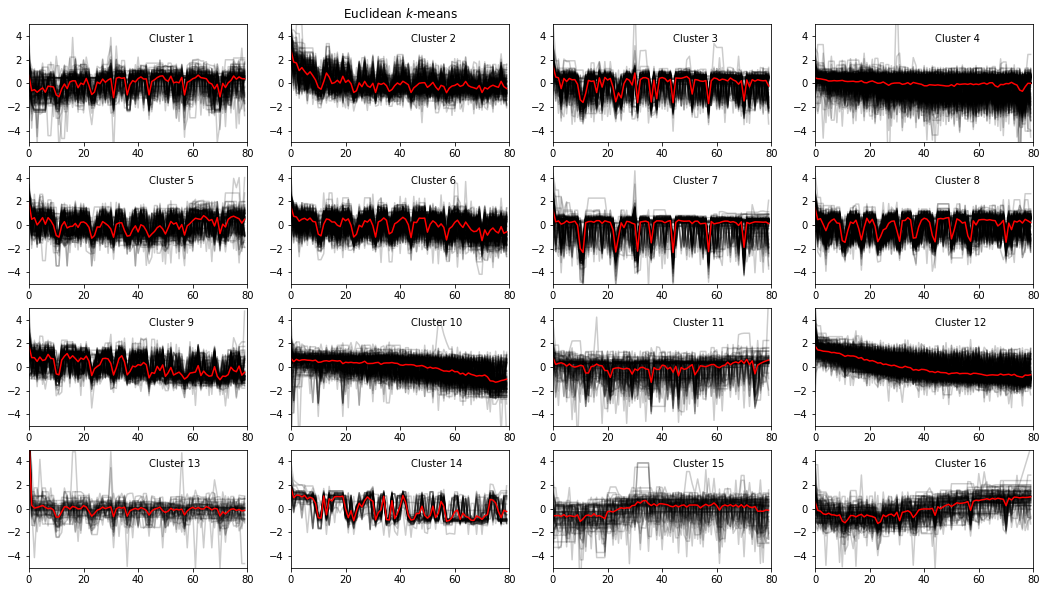

In [33]:
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=16, n_jobs=-1, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)

plt.figure(figsize=(18,10))
for yi in range(16):
    plt.subplot(4, 4, yi + 1)
    for xx in X_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-5, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

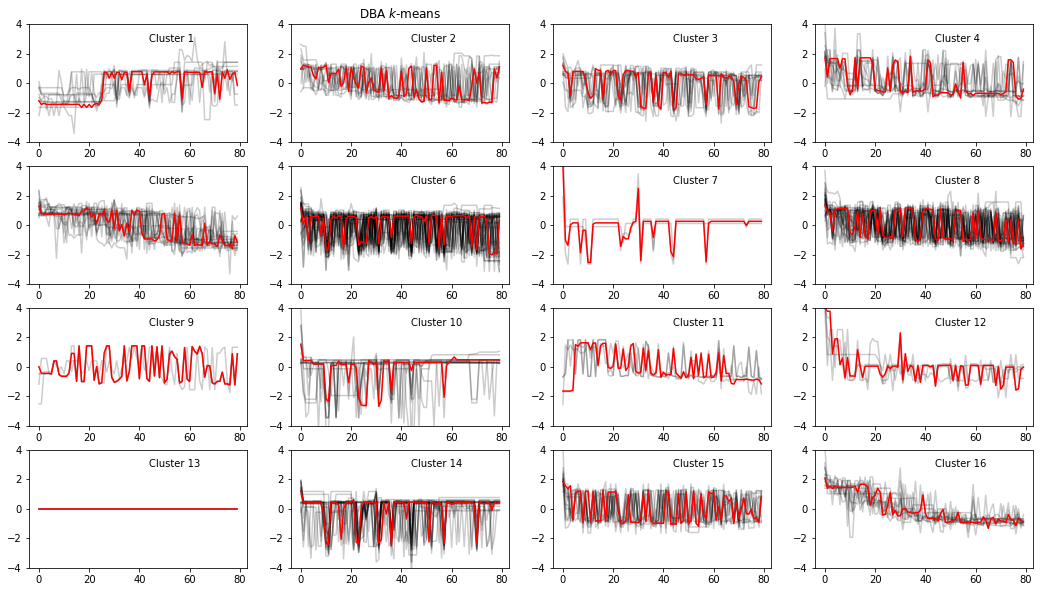

In [34]:

y_pred = model_m50.predict(X_train)
def plot_model_classes(model):
    plt.figure(figsize=(18,10))
    for yi in range(16):
        plt.subplot(4, 4, 1 + yi, autoscalex_on=True)
        ok_ind = [y_pred[0:200] == yi][0]
        sub =  X_train[0:200]
        for ind, xx in enumerate(sub):
            if ok_ind[ind]:
                plt.plot(np.array(xx).ravel(), "k-", alpha=.2)
        plt.plot(model.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("DBA $k$-means")

plot_model_classes(model_m50)

In [35]:
X_train = []
class MarkovModel:


def trainMarkov(data, previousStateNum=3):
    """
    "Trains" a Markov Chain model by looking at frequencies of in/out.
    This should serve as a baseline model that our fancier models should outperform not matter what.

    :param data:
    :param previousStateNum:
    :return:
    """


IndentationError: expected an indented block (3281760761.py, line 5)